# Transfer learning

## 1. Disclaimer

This notebook follows official PyTorch [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#id1). Almost all of the code is identical with the tutorial

## 2. Imports

In [7]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

## 3. System status

In [8]:
print('cudnn version: ' + str(torch.backends.cudnn.version()))
print('cuda  version: ' + str(torch.version.cuda))

cudnn version: 7005
cuda  version: 9.1.85


## 4. Load the data

### Set some constants

In [9]:
# Define few constants
use_gpu = torch.cuda.is_available()
print('Is  CUDA used: ' + str(use_gpu))

# Pre-proc constants
normalize_mean = [0.485, 0.456, 0.406]
normalize_std  = [0.229, 0.224, 0.225]
data_dir = '/home/alkit/code_excercise/PyTorch/data/hymenoptera_data'

data_types = ['train', 'val']

# Model parameters
learning_rate = 0.001
momentum = 0.9
gamma = 0.1
step_size = 7
num_epochs = 25

Is  CUDA used: True


In [10]:


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224)
        , transforms.RandomHorizontalFlip()
        , transforms.ToTensor()
        , transforms.Normalize(normalize_mean, normalize_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256)
        , transforms.CenterCrop(224)
        , transforms.ToTensor()
        , transforms.Normalize(normalize_mean, normalize_std)    
    ]),
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x)
        ,data_transforms[x]
    )
    for x in  data_types
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x]
        , batch_size = 4
        , shuffle = True
        , num_workers = 4
    )
    
    for x in  data_types
}

dataset_sizes = {
    x: len(image_datasets[x])
    for x in data_types
}

class_names = image_datasets['train'].classes


## 5. Visualize a few images

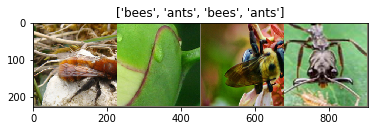

In [11]:
def imshow(inp, title=None):
    """Imshow fro Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(normalize_mean)
    std = np.array(normalize_std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # puse  a bit  so  that plots  are  updates
    
# Get a bathc of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title = [class_names[x] for x in  classes])

## 6. Training the model

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in  range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in data_types:
            if phase == 'train':
                scheduler.step()
                model.train(True) # Set the model to training mode
            else:
                model.train(False) # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for data in  dataloaders[phase]:
                # get the inputs
                inputs, labels = data
                
                # wrap  them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                
                # backward + optimize only if training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                # statstics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc  = running_corrects / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## 7. Visualize the model predictions

In [13]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

## 8. Finetunning the ConvNet

In [14]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=momentum)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=step_size, gamma=gamma)

### Train  and evaluate

In [15]:
model_ft = train_model(
    model_ft
    , criterion
    , optimizer_ft
    , exp_lr_scheduler
    , num_epochs=25
)

Epoch 0/24
----------
train Loss: 0.4877 Acc: 0.7664
val Loss: 0.2816 Acc: 0.8497

Epoch 1/24
----------
train Loss: 0.5553 Acc: 0.7746
val Loss: 0.2043 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4550 Acc: 0.8115
val Loss: 0.1813 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.5389 Acc: 0.7664
val Loss: 0.2979 Acc: 0.8693

Epoch 4/24
----------
train Loss: 0.5295 Acc: 0.7828
val Loss: 0.2082 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.4246 Acc: 0.8279
val Loss: 0.4378 Acc: 0.8562

Epoch 6/24
----------
train Loss: 0.4067 Acc: 0.8402
val Loss: 0.1921 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3253 Acc: 0.8648
val Loss: 0.1864 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3383 Acc: 0.8648
val Loss: 0.1607 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.2914 Acc: 0.8811
val Loss: 0.1492 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3241 Acc: 0.8525
val Loss: 0.1527 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3187 Acc: 0.8566
val Loss: 0.1806 Acc: 0.9412

Ep

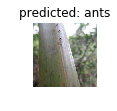

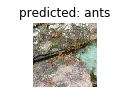

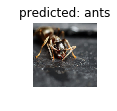

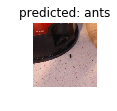

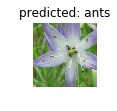

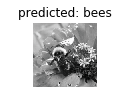

In [16]:
visualize_model(model_ft)

## 10. ConvNet as fixed feature extractor
Fix the whole network apart from the final layer with ```requires_grad == False``` so the gradient is not computed in `backward()`

In [17]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

#Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()
    
criterion = nn.CrossEntropyLoss()

#Observe that only parameters of final layer are being optimized as
#opposed to before
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=learning_rate, momentum=momentum)

#Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=step_size, gamma=gamma)


## 11.Train and evaluate

In [18]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs = num_epochs)

Epoch 0/24
----------
train Loss: 0.7309 Acc: 0.5779
val Loss: 0.5301 Acc: 0.7124

Epoch 1/24
----------
train Loss: 0.4918 Acc: 0.7992
val Loss: 0.2486 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.5942 Acc: 0.7418
val Loss: 0.1979 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.5125 Acc: 0.7828
val Loss: 0.1726 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.6214 Acc: 0.7459
val Loss: 0.2507 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.5285 Acc: 0.7623
val Loss: 0.1777 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.4328 Acc: 0.8484
val Loss: 0.3215 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.4767 Acc: 0.7869
val Loss: 0.1983 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.4192 Acc: 0.8115
val Loss: 0.1948 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3811 Acc: 0.8279
val Loss: 0.1778 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.2904 Acc: 0.8607
val Loss: 0.1726 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3777 Acc: 0.8279
val Loss: 0.1860 Acc: 0.9346

Ep

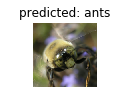

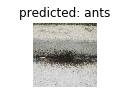

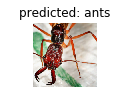

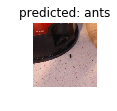

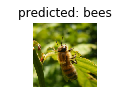

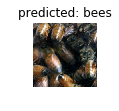

In [19]:
visualize_model(model_conv)

plt.ioff()
plt.show()
